## Extracting features of wallet data

In [ ]:
import pandas as pd
import numpy as np

from WalletWatch_HAR_ITZ.src.predictor import sanitize_float

df = pd.read_csv(r'C:\Users\ayemi\OneDrive\Documents\The_Haritz\data\cleaned_wallet_transactions.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

features = []

for wallet, group in df.groupby('wallet'):
    total_transactions = len(group)
    inflow = group[group['direction'] == 'inflow']['amount'].sum()
    outflow = group[group['direction'] == 'outflow']['amount'].sum()
    inflow_outflow_ratio = inflow / outflow if outflow != 0 else np.inf

    frist_time = group['timestamp'].min()
    last_time = group['timestamp'].max()
    duration_days = (last_time - frist_time).total_seconds() / (24 * 3600)
    transactions_per_day = total_transactions / duration_days if duration_days > 0 else total_transactions

features.append({
    'wallet_address': wallet,
    'total_transactions': sanitize_float(total_transactions),
    'inflow': sanitize_float(round(inflow, 4)),
    'outflow': sanitize_float(round(outflow, 4)),
    'inflow_outflow_ratio': sanitize_float(round(inflow_outflow_ratio, 4)),
    'duration_days': sanitize_float(round(duration_days, 2)),
    'transactions_per_day': sanitize_float(round(transactions_per_day, 2))
})


features_df = pd.DataFrame(features)

print(features_df.head())

                                 wallet_address  total_transactions    inflow  \
0  25S13Dzogrcq49EMUdhkhsfUBFSSAgTHJTgcWfcY51nG                  96  617.3939   
1  2P7CZCzXynAq5PYgs3WHZnJ3XgWneQ5mTub2QCH4vQ13                  54    8.8534   
2  2bFRjjbGHwLHioHKePHxWcZmhgin2fJS7APagagTEn3k                 126    0.0000   
3  2c5WdJJZtcgtguNqRKaHPi2JqaUXCkVA7w8hwX2yq9Dn                  73  263.8722   
4  2rptxFkDpPodk4kMpJ7YXXSkchfpJ9v2MDTxFJ2osHEX                   3    0.0877   

     outflow  inflow_outflow_ratio  duration_days  transactions_per_day  
0  1047.4451                0.5894           1.27                 75.80  
1    65.6640                0.1348           0.00              51840.00  
2   269.4607                0.0000           0.29                430.51  
3   494.0605                0.5341           0.37                197.74  
4     0.0860                1.0206           0.03                100.31  


### Token Mint Timing vs Dump Timing

In [40]:
# mint transactions
mint_df = df[df['amount'] > 0].copy()
mint_df.rename(columns={'timestamp': 'mint_timestamp'}, inplace=True)

first_mint_per_token = mint_df.groupby('token_mint')['mint_timestamp'].min().reset_index()

# dump transactions
dump_df = df[df['amount'] < 0].copy()
dump_df.rename(columns={'timestamp': 'dump_timestamp'}, inplace=True) 

dump_joined = pd.merge(dump_df, first_mint_per_token, on='token_mint', how='inner')
dump_joined['mint_timestamp'] = (dump_joined['dump_timestamp'] - dump_joined['mint_timestamp']).dt.total_seconds() / (60)

mint_dump_summary = dump_joined.groupby('wallet').agg(
    {"token_mint":"nunique",
    "mint_timestamp":"mean"}
).reset_index()

mint_dump_summary.rename(columns={"token_mint":"minted_tokens"}, inplace=True)
mint_dump_summary.rename(columns={"mint_timestamp":"avg_mint_time"}, inplace=True)
mint_dump_summary.rename(columns={"wallet":"wallet_address"}, inplace=True)

# merge with features_df
features_df = pd.merge(features_df, mint_dump_summary, on='wallet_address', how='left')
features_df['avg_mint_time'] = features_df['avg_mint_time'].fillna(0)
features_df.fillna(0, inplace=True)

# conn = sqlite3.connect(r'C:\Users\ayemi\OneDrive\Documents\The_Haritz\data\wallet_features.db')
# features_df.to_sql('wallet_features', conn, if_exists='replace', index=False)
# conn.close()

print(features_df.head())


                                 wallet_address  total_transactions    inflow  \
0  25S13Dzogrcq49EMUdhkhsfUBFSSAgTHJTgcWfcY51nG                  96  617.3939   
1  2P7CZCzXynAq5PYgs3WHZnJ3XgWneQ5mTub2QCH4vQ13                  54    8.8534   
2  2bFRjjbGHwLHioHKePHxWcZmhgin2fJS7APagagTEn3k                 126    0.0000   
3  2c5WdJJZtcgtguNqRKaHPi2JqaUXCkVA7w8hwX2yq9Dn                  73  263.8722   
4  2rptxFkDpPodk4kMpJ7YXXSkchfpJ9v2MDTxFJ2osHEX                   3    0.0877   

     outflow  inflow_outflow_ratio  duration_days  transactions_per_day  \
0  1047.4451                0.5894           1.27                 75.80   
1    65.6640                0.1348           0.00              51840.00   
2   269.4607                0.0000           0.29                430.51   
3   494.0605                0.5341           0.37                197.74   
4     0.0860                1.0206           0.03                100.31   

   minted_tokens  avg_mint_time  
0            0.0       0.000

### Fast Dumper Logic

In [41]:
early_buy_mmins = 10
fast_dump_mmins = 10    

first_mint_time = df[df['amount'] > 0].groupby('token_mint')['timestamp'].min().reset_index()
first_mint_time.rename(columns={'timestamp': 'mint_timestamp'}, inplace=True)  

df_with_mint = pd.merge(df, first_mint_time, on='token_mint', how='left')
df_with_mint['mminutes_since_mint'] = (df_with_mint['timestamp'] - df_with_mint['mint_timestamp']).dt.total_seconds() / 60

early_buys = df_with_mint[
    (df_with_mint['amount'] == 0) &
    (df_with_mint['amount'] > 0) &
    (df_with_mint['mminutes_since_mint'] <= early_buy_mmins)
]

fast_dumps = df_with_mint[
    (df_with_mint['amount'] == 0) &
    (df_with_mint['amount'] < 0) &
    (df_with_mint['mminutes_since_mint'] <= fast_dump_mmins)
]

early_buyers = set(early_buys['wallet'].unique())
fast_dumpers = set(fast_dumps['wallet'].unique())
early_pump_and_dump = early_buyers.intersection(fast_dumpers)


features_df['early_pump_and_dump_flag'] = features_df['wallet_address'].isin(early_pump_and_dump).astype(int)


print(features_df[['wallet_address', 'early_pump_and_dump_flag']].value_counts())


wallet_address                                early_pump_and_dump_flag
25S13Dzogrcq49EMUdhkhsfUBFSSAgTHJTgcWfcY51nG  0                           1
2P7CZCzXynAq5PYgs3WHZnJ3XgWneQ5mTub2QCH4vQ13  0                           1
2bFRjjbGHwLHioHKePHxWcZmhgin2fJS7APagagTEn3k  0                           1
2c5WdJJZtcgtguNqRKaHPi2JqaUXCkVA7w8hwX2yq9Dn  0                           1
2rptxFkDpPodk4kMpJ7YXXSkchfpJ9v2MDTxFJ2osHEX  0                           1
3VoTsHVWApR4t4sKJHbRGs2YGzE7qGQEwU85GkohueNe  0                           1
3qis3eG4JPqk4Eoxg8R9ogJ7doEETSZmKxqWjCWaWe79  0                           1
5FRGPJgGWbHwqNBzc3VPB9QJ8ZYHVfJf79dxhdBbdtfJ  0                           1
5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr  0                           1
5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1  0                           1
5tzFkiKscXHK5ZXCGbXZxdw7gTjjD1mBwuoFbhUvuAi9  0                           1
73hZsLHDXkv9hVEUTGGeQtNSG5zaQUMnkRQMYRiqFfJY  0                           1
7HdZJzZV1Va6H2Kvy

In [42]:
features_df.to_csv(r'C:\Users\ayemi\OneDrive\Documents\The_Haritz\data\wallet_features.csv', index=False)

features_df

,wallet_address,total_transactions,inflow,outflow,inflow_outflow_ratio,duration_days,transactions_per_day,minted_tokens,avg_mint_time,early_pump_and_dump_flag
0,25S13Dzogrcq49EMUdhkhsfUBFSSAgTHJTgcWfcY51nG,96,617.3939,1047.4451,0.5894,1.27,75.80,0.0,0.000000,0
1,2P7CZCzXynAq5PYgs3WHZnJ3XgWneQ5mTub2QCH4vQ13,54,8.8534,65.6640,0.1348,0.00,51840.00,2.0,0.427451,0
2,2bFRjjbGHwLHioHKePHxWcZmhgin2fJS7APagagTEn3k,126,0.0000,269.4607,0.0000,0.29,430.51,0.0,0.000000,0
3,2c5WdJJZtcgtguNqRKaHPi2JqaUXCkVA7w8hwX2yq9Dn,73,263.8722,494.0605,0.5341,0.37,197.74,0.0,0.000000,0
4,2rptxFkDpPodk4kMpJ7YXXSkchfpJ9v2MDTxFJ2osHEX,3,0.0877,0.0860,1.0206,0.03,100.31,0.0,0.000000,0
5,3VoTsHVWApR4t4sKJHbRGs2YGzE7qGQEwU85GkohueNe,60,40.3566,955.9569,0.0422,0.09,660.05,2.0,200.838889,0
6,3qis3eG4JPqk4Eoxg8R9ogJ7doEETSZmKxqWjCWaWe79,60,87.9051,952.2865,0.0923,0.00,64800.00,0.0,0.000000,0
7,5FRGPJgGWbHwqNBzc3VPB9QJ8ZYHVfJf79dxhdBbdtfJ,60,261.7925,881.5425,0.2970,0.00,65620.25,0.0,0.000000,0
8,5Hr7wZg7oBpVhH5nngRqzr5W7ZFUfCsfEhbziZJak7fr,200,0.0000,0.0000,0.0000,0.00,17280000.00,0.0,0.000000,0
9,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,38,0.0000,0.0000,inf,0.00,38.00,7.0,9960.368627,0


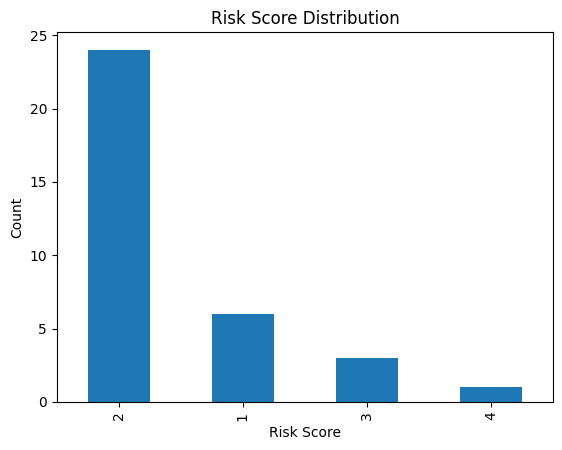

In [48]:
import matplotlib.pyplot as plt
# adding a risk score column
features_df['risk_score'] = 0
features_df.loc[features_df['total_transactions'] > 100, 'risk_score'] += 1
features_df.loc[features_df['inflow_outflow_ratio'] > 2, 'risk_score'] += 1
features_df.loc[features_df['transactions_per_day'] > 10, 'risk_score'] += 1
features_df.loc[features_df['avg_mint_time'] < 5, 'risk_score'] += 1
features_df.loc[features_df['early_pump_and_dump_flag'] == 1, 'risk_score'] += 1
features_df['risk_score'] = features_df['risk_score'].astype(int)
features_df['risk_score'].value_counts().plot(kind='bar')

plt.title('Risk Score Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.savefig(r'C:\Users\ayemi\OneDrive\Documents\The_Haritz\data\risk_score_distribution.png')
plt.show()



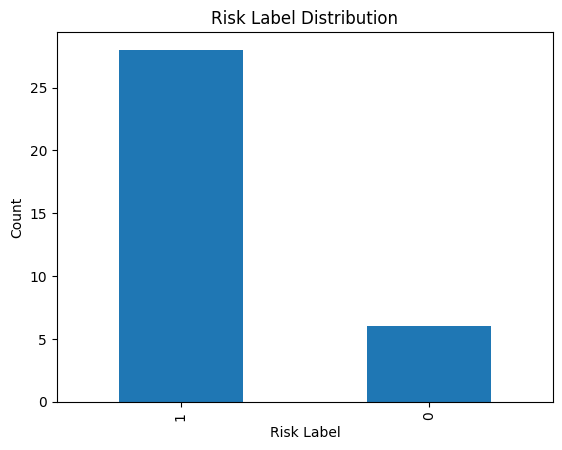

In [47]:
features_df['risk_label'] = features_df['risk_score'].apply(lambda x: 1 if x >= 2 else 0)
features_df['risk_label'].value_counts().plot(kind='bar')
plt.title('Risk Label Distribution')
plt.xlabel('Risk Label')
plt.ylabel('Count')
plt.savefig(r'C:\Users\ayemi\OneDrive\Documents\The_Haritz\data\risk_label_distribution.png')
plt.show()

In [49]:
features_df.to_csv(r'C:\Users\ayemi\OneDrive\Documents\The_Haritz\data\wallet_features_with_risk_score.csv', index=False)
features_df['risk_score'].value_counts().to_csv(r'C:\Users\ayemi\OneDrive\Documents\The_Haritz\data\risk_score_distribution.csv')